<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Web APIs & NLP

## Problem Statement

We are a group of home improvement consultants that provide suggestions on how to refurbish the houses in selected neighborhoods in Ames, Iowa, including selecting the best features for homeowners to renovate, in order to improve the value of their homes in a cost-effective way.

Based on the provided data, we will:
- build several multiple linear regression models and select one best-performing model as our production model
- based on our production model, explore and  recommend important features for home improvment
- build models for selected neighorboods, explore and  recommend important features for home improvment

## Background

House value are influented by the following factors:([*source*](https://www.opendoor.com/w/blog/factors-that-influence-home-value))
- Neighborhood comps
- Location
- Home size and usable space
- Age and condition
- Upgrades and updates
- The local market
- Economic indicators
- Interest rates

As home improvement consultants, we are more interested at the factors or features which can be improved on the exsiting houses. 


## Dataset and Data Directory
- The dataset  ([*source*](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/data)) contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.
- The Dataset has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers). ([*source*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))
- Some important features are listed as below 


|Feature|Type|Description|
|---|---|---|
|**SalePrice**|*Continuous*|sale price, we will treat it as house value| 
|**Neighborhood**|*nominal*|Physical locations within Ames city limits|
|**Overall Qual**|*ordinal*|Rates the overall material and finish of the house|
|**Year Built**|*Discrete*|Original construction date|
|**Mas Vnr Type**|*nominal*|Masonry veneer type|
|**Mas Vnr Area**|*Continuous*|PMasonry veneer area in square feet|
|**Foundation**|*Nominal*| Type of foundation|
|**BsmtFin Type 1**|*Ordinal*| Rating of basement finished area| 
|**BsmtFin SF 1**|*Continuous*|Type 1 finished square feet|
|**Total Bsmt SF**|*Continuous*|Total square feet of basement area|
|**Gr Liv Area**|*Continuous*|Above grade (ground) living area square feet|
|**Fireplaces**|*Discrete*|Number of fireplaces|
|**Garage Area**|*Continuous*|Size of garage in square feet|
|**Open Porch SF**|*Continuous*| Open porch area in square feet|
|**HeatingQC**|*Ordinal*|Heating quality and condition|
|**Bedroom**|*Discrete*|Bedrooms above grade (does NOT include basement bedrooms)|
|**Kitchen**|*Discrete*|Kitchens above grade|
|**KitchenQual**|*Ordinal*|Kitchen quality|
|**TotRmsAbvGrd**|*Discrete*|Total rooms above grade (does not include bathrooms)|


# Import libraries

In [68]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

#from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay




import pickle
import requests
import time



# define some functions

# pickle

In [43]:
df = pickle.load(open('../datasets/data.pkl', 'rb'))

In [44]:
df.shape

(1999, 2)

In [45]:
df.head(100)

,subreddit,title + selftext
0,AskWomen,What podcasts serve as confidence booster for ...
1,AskWomen,How did you get rid of an old friend who alway...
2,AskWomen,Why do they? [removed]
3,AskWomen,Why do? [removed]
4,AskWomen,Why do men? [removed]
...,...,...
95,AskWomen,"women of Reddit, what are your lucrative side ..."
96,AskWomen,How to approach my partner about their porn us...
97,AskWomen,"Woman of reddit married to doctors, what are t..."
98,AskWomen,What would you do when you realize the guy you...


### Convert subreddit into binary labels:

In [46]:
df['title + selftext'] = df['title + selftext'].astype("str")
df['subreddit'] = df['subreddit'].map({'AskWomen' : 0, 'AskMen' : 1})
df.head()

,subreddit,title + selftext
0,0,What podcasts serve as confidence booster for ...
1,0,How did you get rid of an old friend who alway...
2,0,Why do they? [removed]
3,0,Why do? [removed]
4,0,Why do men? [removed]


In [47]:
X = df['title + selftext']
y = df['subreddit']

In [48]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

0   0.50
1   0.50
Name: subreddit, dtype: float64

In [49]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         1999 non-null   int64 
 1   title + selftext  1999 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## Pre-Processing

In [51]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe = Pipeline([
                ('cvec', CountVectorizer()),
                ('nb', MultinomialNB())
                ])

In [52]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_params = {
                'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
                'cvec__min_df': [2, 3],
                'cvec__max_df': [.9, .95],
                'cvec__ngram_range': [(1,1), (1,2)]
                }

In [53]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

In [54]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [55]:
# What's the best score?
print(gs.best_score_)

0.662429425904187


In [56]:
# Score model on training set.
gs.score(X_train, y_train)

0.8722927557879014

In [57]:
# Score model on testing set.
gs.score(X_test, y_test)

0.6545454545454545

In [58]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

C:\Users\olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


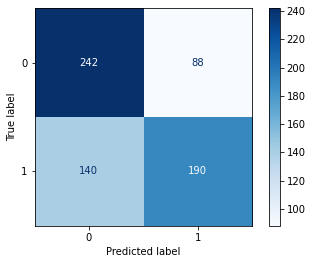

In [59]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

## Modeling Using the TfidfVectorizer + Naive Bayes

In [97]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_nb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('nb', MultinomialNB())
                    ])

In [98]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_nb_params = {
                    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)]
                    }

In [99]:
# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # what object are we optimizing?
                        param_grid = pipe_tvec_nb_params, # what parameters values are we searching?
                       cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

In [100]:
# Fit GridSearch to training data.
gs_tvec_nb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             scoring='roc_auc')

In [101]:
# Score model on training set.
gs_tvec_nb.score(X_train, y_train)

0.977610824799768

In [102]:
# Score model on testing set.
gs_tvec_nb.score(X_test, y_test)

0.7612396694214877

In [103]:
# Get predictions
preds_tvec_nb = gs_tvec_nb.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec_nb).ravel()

C:\Users\olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


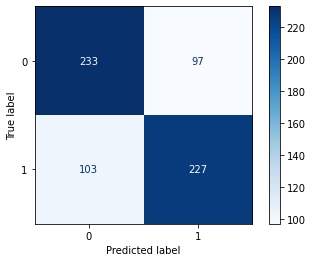

In [104]:
# View confusion matrix
plot_confusion_matrix(gs_tvec_nb, X_test, y_test, cmap='Blues', values_format='d');

## Modeling Using the TfidfVectorizer + RandomForest

In [105]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_rf = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('rf',RandomForestClassifier(random_state=42))
                    ])

In [106]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_rf_params = {
                    #params of TfidfVectorizer
                    'tvec__max_features': [2_000, 3_000, 4_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
                    #params of random forest
                    'rf__n_estimators' : [10, 50, 100, 250],
                    'rf__max_depth' : [5, 10, 20],
                    'rf__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [107]:
# Instantiate GridSearchCV.
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, # what object are we optimizing?
                        param_grid = pipe_tvec_rf_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

In [108]:
# Fit GridSearch to training data.
gs_tvec_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10},
                                              {0: 1, 1: 25}],
                         'rf__max_depth': [5, 10, 20],
                         'rf__n_estimators': [10, 50, 100, 250],
                         'tvec__max_features': [2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             scoring='roc_auc')

In [109]:
# Best performing model and its corresponding hyperparameters
gs_tvec_rf.best_params_

{'rf__class_weight': None,
 'rf__max_depth': 20,
 'rf__n_estimators': 250,
 'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [110]:
# Score model on training set.
gs_tvec_rf.score(X_train, y_train)

0.9953093278004596

In [111]:
# Score model on testing set.
gs_tvec_rf.score(X_test, y_test)

0.7980165289256198

In [112]:
# Get predictions
preds_tvec_rf = gs_tvec_rf.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec_rf).ravel()

C:\Users\olive\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


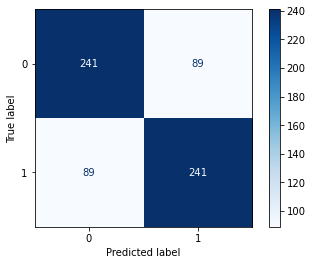

In [113]:
# View confusion matrix
plot_confusion_matrix(gs_tvec_rf, X_test, y_test, cmap='Blues', values_format='d');

## Conclusions and Recommendations

- We built several models and found lasso models had the best performance
- Based on the lasso model, we analyzed and found ' BsmtFin SF 1' and 'Fireplaces' as  recommended features for home improvements
- We built models for selected neighborhoods and  recommended some feature for home improvement
- The neighorhood models also suggest that it is better to do home improvement for newer houses or high value houses because it can create more value 

## Limitation and Future Enhancement
- Our 3 multiple regression models have very similar performance, indicating our model might be underfitting, adding more futures may increase model performance
- Our models cannot meet the LINE assumption, other non-regression models should be considered
- Many data are highly imbalance and barely useful. Data collector might redesign what to be collected in the future
- Many neigbhorhoods have insufficient data to build meaningful models. More data is needed